The long-wave radiation was calculated using the following:

$$ G = \sigma T^3 \epsilon \approx 0.135 $$

When comparing this value with the convection 

$$
G_{\text{cv}} = hS \approx 60
$$

and with the value for the conduction 

$$
G_{\text{cond}} = S \frac{\lambda}{w} \approx 200
$$

it is noticeable that the value of the long-wave radiation is neglectable. 

In [ ]:
# temperature nodes
nθ = 20      # number of temperature nodes
θ = [f'θ{i}' for i in range(nθ)]

# flow-rate branches
nq = 27     # number of flow branches
q = [f'q{i}' for i in range(nq)]


θ = np.linalg.inv(A.T @ G @ A ) @ (A.T @ G @ b + f)
print(f'θ = {np.around(θ, 1)} °C')

print(f'Bathroom = {np.around(θ[5], 1)} °C')
print(f'Living room = {np.around(θ[9], 1)} °C')

The simulation results are considered realistic given the assumption that a temperature controller is only placed in the living room. This design choice leads to significant temperature differences between rooms. If an additional controller had been placed in the bathroom, these differences would likely have been reduced. Moreover, the decision to model the interior door as opaque further contributes to the temperature disparity, as the door is assumed not to allow any heat transfer, effectively acting as a solid barrier.

In the current model, the primary factor influencing the indoor temperature is the outdoor temperature. Additionally, the large glazed area contributes to increased indoor temperatures due to solar heat gain.

It is also important to note that the controller is modeled with a proportional gain (Kp) value of 1000, which assumes an almost ideal response. In real-life applications, such high performance is rarely achieved, and controller behavior tends to be less precise.

One of the main issues identified in the building model is the temperature in the bathroom. As discussed earlier, this is primarily due to the absence of a temperature controller in that space, combined with the fact that the interior door is modeled as opaque, preventing heat transfer between rooms.

Another important aspect is the performance of the controller itself. In the current model, the controller is assumed to operate with near-perfect precision due to a high proportional gain value. To enhance the realism of the simulation, this value should be further examined and adjusted to better reflect actual control system performance.

Additionally, the model could be improved by modifying the window design. The current windows are large and modeled with only double glazing, which contributes significantly to heat gain and loss. Improving the window properties by lowering the U-value and/or reducing the window size would result in a more energy-efficient building model. However, it is important to note that reducing the glazed area would also decrease the availability of natural light, introducing a separate set of considerations related to daylight access and occupant comfort.

# DYNAMIC MODEL

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctrl
import time

import dm4bem
from dm4bem import read_epw, sol_rad_tilt_surf

In [6]:
controller = True
Kp = 1e3    # W/°C, controller gain

neglect_air_capacity = False
neglect_glass_capacity = False

explicit_Euler = True

imposed_time_step = False
Δt = 3600    # s, imposed time step 

## State-space representation

In [7]:
# MODEL
# =====
# Thermal circuits
TC = dm4bem.file2TC('toy_model.csv', name='', auto_number=False)

# by default TC['G']['q1'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q1'] = Kp     # G1 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ5'] = 0       # C6, capacity of vertex θ6 (air)
if neglect_glass_capacity:
    TC['C']['θ9'] = 0       # C7, capacity of vertex θ7 (glass) 

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
dm4bem.print_TC(TC)

A:
      θ0   θ1   θ2   θ3   θ4   θ5   θ6   θ7   θ8   θ9  θ10  θ11  θ12  θ13  \
q0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
q2   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q3  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q4   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q5   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q6   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q7   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q8   0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q9   0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
q10  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0   
q11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0

The condition for numerical stability of Euler explicit integration

In [8]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

dt = 120 s = 2.0 min


## Input data set

### One-hour time step

In [9]:
start_date = '02-01 12:00:00'
end_date = '02-02 18:00:00'

start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = 'FRA_AR_Lyon-Bron.AP.074800_TMYx.2004-2018.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

2000-02-01 12:00:00 	start date
2000-02-02 18:00:00 	end date


## Input data set

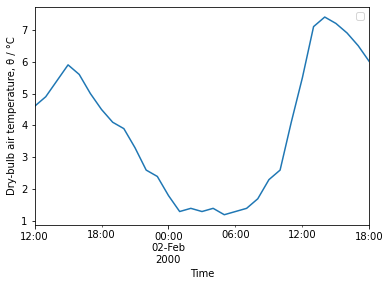

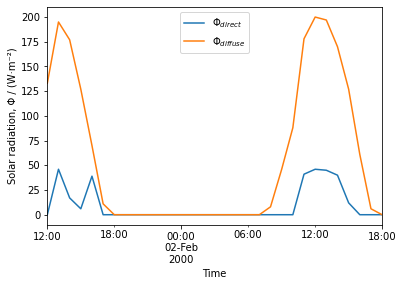

In [10]:
# Temperature sources
To = weather['temp_air']

To.plot()
plt.xlabel("Time")
plt.ylabel("Dry-bulb air temperature, θ / °C")
plt.legend([])
plt.show()

weather[['dir_n_rad', 'dif_h_rad']].plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation, Φ / (W·m⁻²)")
plt.legend(['$Φ_{direct}$', '$Φ_{diffuse}$'])
plt.show()

In [11]:
# total solar irradiance
wall_out = pd.read_csv('walls_out.csv')
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])
print(wall_out)

   ID  type  Area   β  γ  albedo  T0  Q0  Q1  h0  h1    α0   α1    ε0   ε1  \
0  w0     0    51  90  0    0.45  To  Φo  Φi  25   8  0.25  0.3  0.85  0.7   

      y  
0  [-1]  


In [12]:
print(f"{rad_surf.loc['2000-02-02 12:00']['direct']:.0f} W/m²")
print(f"Mean. direct irradiation: {rad_surf['direct'].mean():.0f} W/m²")
print(f"Max. direct irradiation:  {rad_surf['direct'].max():.0f} W/m²")
print(f"Direct solar irradiance is maximum on {rad_surf['direct'].idxmax()}")

40 W/m²
Mean. direct irradiation: 7 W/m²
Max. direct irradiation:  40 W/m²
Direct solar irradiance is maximum on 2000-02-02 12:00:00+01:00


The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [13]:
Etot = rad_surf.sum(axis=1)

##### Flow rate sources

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the [absorptance](https://en.m.wikipedia.org/wiki/Absorptance) of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total [solar irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall, W/m².

In [14]:
# solar radiation absorbed by the outdoor surface of the wall
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot
print(Φo)

2000-02-01 12:00:00+01:00    1933.155000
2000-02-01 13:00:00+01:00    3512.661828
2000-02-01 14:00:00+01:00    2782.969174
2000-02-01 15:00:00+01:00    1901.569813
2000-02-01 16:00:00+01:00    1248.585456
2000-02-01 17:00:00+01:00     159.885000
2000-02-01 18:00:00+01:00       0.000000
2000-02-01 19:00:00+01:00       0.000000
2000-02-01 20:00:00+01:00       0.000000
2000-02-01 21:00:00+01:00       0.000000
2000-02-01 22:00:00+01:00       0.000000
2000-02-01 23:00:00+01:00       0.000000
2000-02-02 00:00:00+01:00       0.000000
2000-02-02 01:00:00+01:00       0.000000
2000-02-02 02:00:00+01:00       0.000000
2000-02-02 03:00:00+01:00       0.000000
2000-02-02 04:00:00+01:00       0.000000
2000-02-02 05:00:00+01:00       0.000000
2000-02-02 06:00:00+01:00       0.000000
2000-02-02 07:00:00+01:00       0.000000
2000-02-02 08:00:00+01:00     116.280000
2000-02-02 09:00:00+01:00     668.610000
2000-02-02 10:00:00+01:00    1279.080000
2000-02-02 11:00:00+01:00    3273.815440
2000-02-02 12:00

The short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall is:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m²

In [15]:
# window glass properties
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass
S_g  = 7*3

# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot
print(Φi)

2000-02-01 12:00:00+01:00    199.001250
2000-02-01 13:00:00+01:00    361.597541
2000-02-01 14:00:00+01:00    286.482121
2000-02-01 15:00:00+01:00    195.749834
2000-02-01 16:00:00+01:00    128.530856
2000-02-01 17:00:00+01:00     16.458750
2000-02-01 18:00:00+01:00      0.000000
2000-02-01 19:00:00+01:00      0.000000
2000-02-01 20:00:00+01:00      0.000000
2000-02-01 21:00:00+01:00      0.000000
2000-02-01 22:00:00+01:00      0.000000
2000-02-01 23:00:00+01:00      0.000000
2000-02-02 00:00:00+01:00      0.000000
2000-02-02 01:00:00+01:00      0.000000
2000-02-02 02:00:00+01:00      0.000000
2000-02-02 03:00:00+01:00      0.000000
2000-02-02 04:00:00+01:00      0.000000
2000-02-02 05:00:00+01:00      0.000000
2000-02-02 06:00:00+01:00      0.000000
2000-02-02 07:00:00+01:00      0.000000
2000-02-02 08:00:00+01:00     11.970000
2000-02-02 09:00:00+01:00     68.827500
2000-02-02 10:00:00+01:00    131.670000
2000-02-02 11:00:00+01:00    337.010413
2000-02-02 12:00:00+01:00    376.129820


In [16]:
# solar radiation absorbed by the glass
Φa = α_gSW * S_g * Etot

### Schedules
#### Indoor air temperature set-point

$$T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]$$

is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the setpoint indoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$. Let's consider the indoor temperature set-point constant, $T_{i, sp} = 20 \, \mathrm{°C}$.

In [17]:
Ti_day, Ti_night = 20, 16

Tisp = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    index=To.index)

In [18]:
Qa = 120 
To = 15
Φo = 0
Φi = 0
Φa = 0
Etot = 0

### Input data set

In [19]:
# Input data set
input_data_set = pd.DataFrame({'To': To, 'Tisp': Tisp,
                               'Φo': Φo, 'Φi': Φi, 'Qa': Qa,  'Φa': Φa,
                               'Etot': Etot})

In [20]:
input_data_set.to_csv('input_data_set.csv')
input_data_set

,To,Tisp,Φo,Φi,Qa,Φa,Etot
2000-02-01 12:00:00+01:00,15,20,0,0,120,0,0
2000-02-01 13:00:00+01:00,15,20,0,0,120,0,0
2000-02-01 14:00:00+01:00,15,20,0,0,120,0,0
2000-02-01 15:00:00+01:00,15,20,0,0,120,0,0
2000-02-01 16:00:00+01:00,15,20,0,0,120,0,0
2000-02-01 17:00:00+01:00,15,20,0,0,120,0,0
2000-02-01 18:00:00+01:00,15,20,0,0,120,0,0
2000-02-01 19:00:00+01:00,15,20,0,0,120,0,0
2000-02-01 20:00:00+01:00,15,20,0,0,120,0,0
2000-02-01 21:00:00+01:00,15,20,0,0,120,0,0


### Resample input data set

The weather data and the scheduled sources are at the time-step of 1 h. The data needs to be resampled at time step `dt` used for numerical integration.

In [21]:
input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')
input_data_set.head()

,To,Tisp,Φo,Φi,Qa,Φa,Etot
2000-02-01 12:00:00+01:00,15.0,20.0,0.0,0.0,120.0,0.0,0.0
2000-02-01 12:02:00+01:00,15.0,20.0,0.0,0.0,120.0,0.0,0.0
2000-02-01 12:04:00+01:00,15.0,20.0,0.0,0.0,120.0,0.0,0.0
2000-02-01 12:06:00+01:00,15.0,20.0,0.0,0.0,120.0,0.0,0.0
2000-02-01 12:08:00+01:00,15.0,20.0,0.0,0.0,120.0,0.0,0.0


## Input vector in time

In the _input data set_ an input, e.g. $T_o$, appears only once. However, the _i nput vector_ may contain the same time series multiple time; for example, in the model presented in 
Figure 1, there are three inputs $T_o$ corresponding to branches $q_0$, $q_8$, and $q_{10}$). Therefore, we need to obtain the _input vector_ from the _input data set_.

The input in time is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where the input data set is:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation absorbed by the outdoor surface of the wall, W;

$\Phi_i$: time series vector of short wave (i.e. solar) radiation absorbed by the indoor surfaces of the wall, W;

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: time series vector of short wave (i.e. solar) radiation absorbed by the window glass, W.

The *input vector* `u` is obtained from the *input data set*, $T_o, T_{i,sp}, \Phi_o, \Phi_i, \dot Q_a, \Phi_a$, by using the order of the sources given in the state-space model, `us`: `q0` = $T_o$, `q2` = $T_o$,`q13` = $T_o$, `q20` = $T_o$, `q25` = $T_o$, `q26` = $T_o$, `q1` = $T_{i,sp}$, `θ0` = $\Phi_o$, `θ19` = $\Phi_o$, `θ4` = $\Phi_i$, `θ6` = $\Phi_i$, `θ8` = $\Phi_i$, `θ15` = $\Phi_i$, `θ5` = $\dot Q_a$, and `θ9` = $\dot Q_a$.

In [22]:
#print(us)
#print(us.index)
#print(input_data_set.columns)    

In [23]:
# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
u.head()

,q0,q1,q2,q13,q20,q25,θ0,θ4,θ5,θ6,θ8,θ9,θ10,θ14,θ15,θ19
2000-02-01 12:00:00+01:00,15.0,20.0,15.0,15.0,15.0,15.0,0.0,0.0,120.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0
2000-02-01 12:02:00+01:00,15.0,20.0,15.0,15.0,15.0,15.0,0.0,0.0,120.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0
2000-02-01 12:04:00+01:00,15.0,20.0,15.0,15.0,15.0,15.0,0.0,0.0,120.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0
2000-02-01 12:06:00+01:00,15.0,20.0,15.0,15.0,15.0,15.0,0.0,0.0,120.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0
2000-02-01 12:08:00+01:00,15.0,20.0,15.0,15.0,15.0,15.0,0.0,0.0,120.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0


## Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [24]:
# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0

## Time integration
The state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

is integrated in time by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

or [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$


where $k = 0, ... , n - 1$.

In [25]:
I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])

## Outputs

From the time variation of state variable $\theta_s$ we obtain the time variation of the output $y$ (i.e., indoor temperature):

$$y = C_s \theta_s + D_s u$$

In [26]:
# outputs
y = (Cs @ θ.T + Ds @  u.T).T

and the variation in time of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [27]:
Kp = TC['G']['q1']     # controller gain
S = 25                   # m², surface area of the living room
q_HVAC = Kp * (u['q1'] - y['θ9']) / S  # W/m²
y['θ9']

2000-02-01 12:00:00+01:00    20.000000
2000-02-01 12:02:00+01:00    19.493333
2000-02-01 12:04:00+01:00    19.799070
2000-02-01 12:06:00+01:00    19.562114
2000-02-01 12:08:00+01:00    19.690687
                               ...    
2000-02-02 17:52:00+01:00    19.188504
2000-02-02 17:54:00+01:00    19.188591
2000-02-02 17:56:00+01:00    19.188677
2000-02-02 17:58:00+01:00    19.188762
2000-02-02 18:00:00+01:00    19.188847
Freq: 120S, Name: θ9, Length: 901, dtype: float64

## Plots

We select the data to plot:

- $T_o$, outdoor temperature, °C;
- $\theta_i$, indoor temperature, °C;
- $E_{tot}$, total solar irradiance, W/m²;
- $q_{HVAC}$, thermal load, i.e., the power that the HVAC system needs to deliver in order to maintain the indoor air temperature at its set-point, W.

In [28]:
data = pd.DataFrame({'To': input_data_set['To'],
                     'θlr': y['θ9'],
                     'θb': y['θ5'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})
print(data)

                             To        θlr         θb  Etot     q_HVAC
2000-02-01 12:00:00+01:00  15.0  20.000000  20.000000   0.0   0.000000
2000-02-01 12:02:00+01:00  15.0  19.493333  20.233333   0.0  20.266667
2000-02-01 12:04:00+01:00  15.0  19.799070  20.305575   0.0   8.037196
2000-02-01 12:06:00+01:00  15.0  19.562114  20.307143   0.0  17.515438
2000-02-01 12:08:00+01:00  15.0  19.690687  20.279113   0.0  12.372530
...                         ...        ...        ...   ...        ...
2000-02-02 17:52:00+01:00  15.0  19.188504  18.204352   0.0  32.459836
2000-02-02 17:54:00+01:00  15.0  19.188591  18.205077   0.0  32.456372
2000-02-02 17:56:00+01:00  15.0  19.188677  18.205797   0.0  32.452931
2000-02-02 17:58:00+01:00  15.0  19.188762  18.206513   0.0  32.449512
2000-02-02 18:00:00+01:00  15.0  19.188847  18.207224   0.0  32.446116

[901 rows x 5 columns]


### Plots using Pandas

The plots mays be done by using `plot` method for DataFrame.

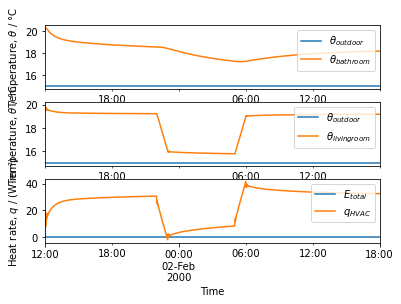

In [29]:
fig, axs = plt.subplots(3, 1)

data[['To', 'θb']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{bathroom}$'],
              loc='upper right')


data[['To', 'θlr']].plot(ax=axs[1],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[1].legend(['$θ_{outdoor}$', '$θ_{living room}$'],
              loc='upper right')


data[['Etot', 'q_HVAC']].plot(ax=axs[2],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[2].set(xlabel='Time')
axs[2].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show();